In [ ]:
!pip install pydicom
#
#sudo apt-get install software-properties-common
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

     |████████████████████████████████| 1.9MB 2.8MB/s 
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [20]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [21]:
import os
os.chdir("drive")
if("悅寧的code" in os.listdir()):
  os.chdir("悅寧的code")
else:
  os.mkdir("悅寧的code")
  os.chdir("悅寧的code")
  

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [24]:
def load_origin_scan(path):
    g = glob.glob(path + '/*.dcm') #方法返回所有匹配的文件路径列表
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber)) #InstanceNumber; A number that identifies this image.

    return slices
    #print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
   # print('RescaleSlope :{}'.format(slices[0].RescaleSlope)
first_patient=load_origin_scan('3D_image')
#print(first_patient[1])

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.55.3.2831162388.564.1417967948.210.2
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.410.200010.99.3.5
(0002, 0013) Implementation Version Name         SH: 'INF_3.8'
(0002, 0016) Source Application Entity Title     AE: 'QCN-OPD2'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 594
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: '20141210'
(0008, 0013) Instance Creation Time            

In [25]:
def load_origin_scan(path):
    g = glob.glob(path + '/*.dcm') #方法返回所有匹配的文件路径列表
    slices = [pydicom.read_file(s) for s in g]
    slices.sort(key=lambda x: int(x.InstanceNumber)) #InstanceNumber; A number that identifies this image.

    return slices
    #print('RescaleIntercept :{}'.format(slices[0].RescaleIntercept))
   # print('RescaleSlope :{}'.format(slices[0].RescaleSlope)
first_patient=load_origin_scan('3D_image')
#print(first_patient)

In [26]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices]) # pixel_array則將返回未壓縮的數據
    #对arrays里面的每个元素变成numpy的数组后，再对每个元素增加一维(至于维度加在哪里，是靠axis控制的)
    image = image.astype(np.int16) #16位有符號的整數 

    # CT掃描邊界之外的灰度值固定為-2000
    image[image == -2000] = 0  ###

    # 
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        #DICOM裡面每個像素儲存的值並不是直接就是HU，而是必須透過DICOM中的Rescale Intercept 和 Rescale Slope經過轉換公式來取得
        #公式Outputunits=m×SV+b 
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float32)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

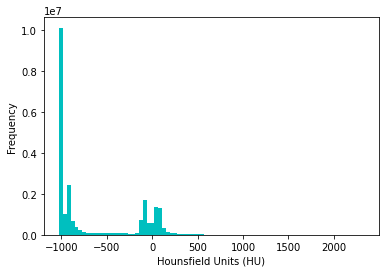

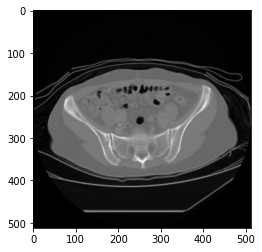

In [27]:
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')#bin 直方圖的柱數
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# 
plt.imshow(first_patient_pixels[55], cmap=plt.cm.gray)
plt.show()

In [28]:
#將DICOM的picel間距和slice之間的間距調出來看看
def load_origin_scan(slices, i):
    print('SliceThickness :{}'.format(slices[i].SliceThickness))#层厚.
    print('Pixel Spacing  :{}'.format(slices[i].PixelSpacing ))#每一张Dicom影像的x方向和y方向上的像素间距
load_origin_scan(first_patient, 31)

SliceThickness :5.000000
Pixel Spacing  :[0.710938, 0.710938]


In [ ]:
image= first_patient_pixels #某病人全部ct轉換後的像素
scan= first_patient #某病人全部ct資料
new_spacing= [1,1,1]
spacing = np.array([scan[1].SliceThickness] + list(scan[1].PixelSpacing), dtype=np.float32)

resize_factor = spacing / new_spacing
new_real_shape = image.shape * resize_factor
new_shape = np.round(new_real_shape)

real_resize_factor = new_shape / image.shape
new_spacing = spacing / real_resize_factor
print(spacing)
print(new_spacing)
print(new_real_shape)
#print(resize_factor)
print(image.shape)
#print(scan)
#print(scan[1].PixelSpacing)

In [29]:
# 縮放整個DICOM圖檔,將每一組照片的pixel間距全部縮放成 1mm×1mm×1mm
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
#first_patient_pixels:某病人全部ct轉換後的像素
#first_patient某病人全部ct資料
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (89, 512, 512)
Shape after resampling	 (445, 364, 364)


In [69]:
def plot_3d1(image):#, threshold=-400

    # Position the scan upright, so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)#原本是(z,x,y)轉置成(x,y,z)
    
    verts, faces,_,_ = measure.marching_cubes_lewiner(p)  #Lewiner行进立方体算法在3d体积数据中找到表面
    fig = plt.figure(figsize=(10, 10)) #figsize：指定figure的宽和高，单位为英寸
    ax = fig.add_subplot(111, projection='3d') #網格  (左右網格大小，上下網格大小)
    

    # Fancy indexing: verts[faces] to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.3, 0.45, 0.75] #顏色
    mesh.set_facecolor(face_color) #各軸的顏色
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0]) #x軸從0到512
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

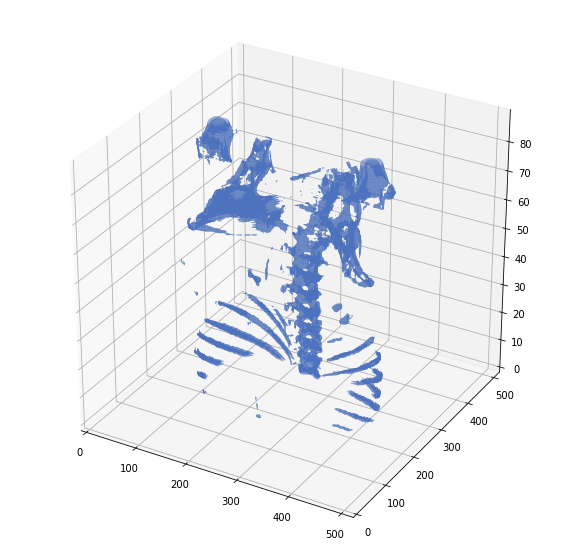

In [70]:
plot_3d1(first_patient_pixels) #pix_resampled

In [86]:
#只保留最大的氣袋（人類軀體內到處都有氣袋）
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True) #每個值出現次數

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None



In [102]:
image= pix_resampled #調整後的像素
binary_image = np.array(image >= -400, dtype=np.int8)+1
#print(binary_image[:1])
labels = measure.label(binary_image)
background_label = labels[0,0,0]
#print(labels[:1])
#print(labels.shape)
#print(pix_resampled.shape)
#print(pix_resampled[:1])
#print(background_label) #1
binary_image[background_label == labels] = 2 #空的地方標示為二
#print(binary_image[1])
fill_lung_structures=True
if fill_lung_structures:
              # For every slice we determine the largest solid structure
  for i, axial_slice in enumerate(binary_image):
    #print(axial_slice-1)
    axial_slice = axial_slice - 1
    labeling = measure.label(axial_slice)
    #print(labeling)
    l_max = largest_label_volume(labeling, bg=0)



    if l_max is not None:
      binary_image[i][labeling != l_max] = 1
print(l_max)

1


In [105]:
image= pix_resampled #調整後的像素
binary_image = np.array(image >= -400, dtype=np.int8)+1
labels = measure.label(binary_image)
background_label = labels[0,0,0]
#print(labels[:1])
print(binary_image[1])

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [103]:
def segment_lung_mask(image, fill_lung_structures=True):

    #确定最大的固体连接组件（人体周围的身体+空气），并将其他组件设置为0。这样可以填充面罩中肺部的结构
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -400, dtype=np.int8)+1 #-320
    labels = measure.label(binary_image) 

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0] #1

    #   Fill the air around the person
    binary_image[background_label == labels] = 2


    # Method of filling the lung structures (that is superior to something like  morphological closing
    if fill_lung_structures:
              # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None:
                binary_image[i][labeling != l_max] = 1


    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1

    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: #
      binary_image[labels != l_max] = 0

    return binary_image

In [37]:
def plot_3d(image):

    # Position the scan upright, so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces,_,_ = measure.marching_cubes_lewiner(p)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    #
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0,200)  # p.shape[0] 1 2
    ax.set_ylim(100,300 )
    ax.set_zlim(0, 200)

    plt.show()


In [38]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

#pix_resampled


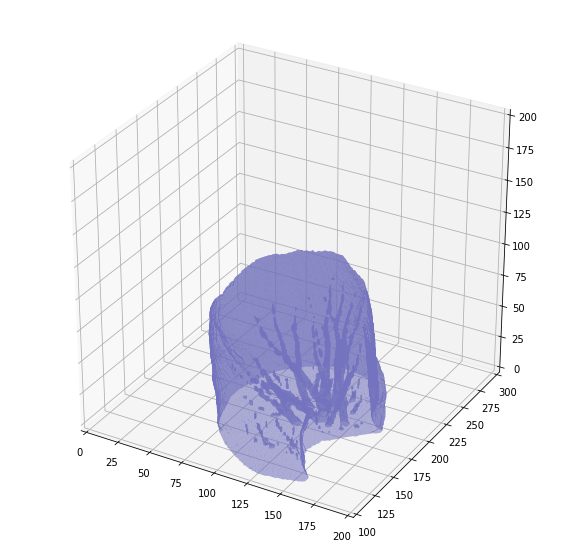

In [39]:
plot_3d(segmented_lungs)#, 0)

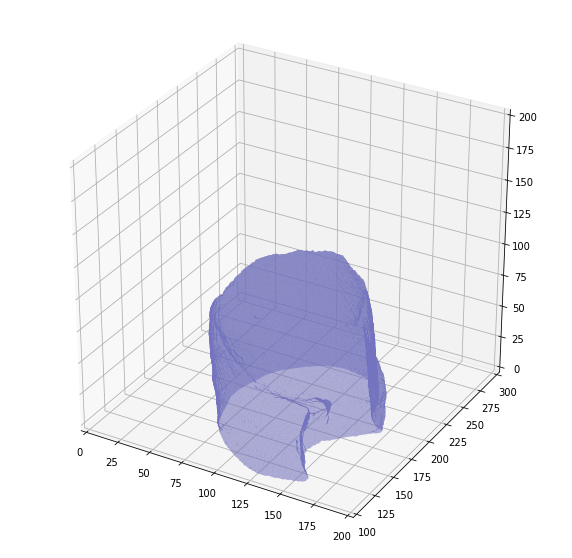

In [41]:
plot_3d(segmented_lungs_fill)

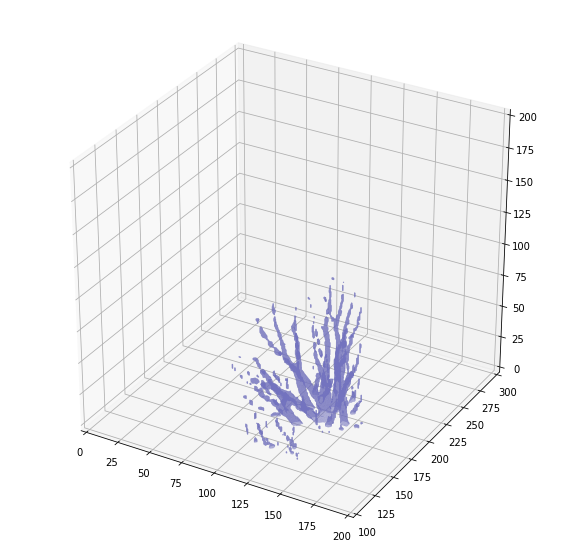

In [40]:
plot_3d(segmented_lungs_fill - segmented_lungs)

In [42]:
import plotly.graph_objects as go

In [43]:
image= segmented_lungs
p = image.transpose(2,1,0)
verts, faces,_,_ = measure.marching_cubes_lewiner(p)
array= verts[faces]
x1,y1,z1= [],[],[]
x2,y2,z2= [],[],[]
x3,y3,z3= [],[],[]
x,y,z= [],[],[]
for i, a in enumerate(array):
  for j, b in enumerate(a):
    x.append(b[0])
    y.append(b[1])
    z.append(b[2])

array_x = np.array(x)
array_y = np.array(y)
array_z = np.array(z)
#fig = go.Figure(data=[go.Mesh3d(x=array_x, y=array_y, z=array_z, color='grey')])
#fig.show()
#print(x[498900:])
#print(array[166300:])
#array.shape

NameError: ignored

In [ ]:
# Poly3DCollection使用方法
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = [0, 2, 1, 1]
y = [0, 0, 1, 0]
z = [0, 0, 0, 1]

vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]

tupleList = zip(x, y, z)

poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
ax.scatter(x,y,z)
ax.add_collection3d(Poly3DCollection(poly3d, facecolors='w', linewidths=1, alpha=0.5))

plt.show()